Libraries:

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import DraperQFTAdder

# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

C:\Users\brayd\AppData\Local\Temp\ipykernel_12364\50878126.py:12: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


Function Definitions:

In [2]:
# Function encodes given integers onto the circuit for two qubits
def encode_numbers_2(qc, num1, num2):
    
    num1_bin = format(num1, '02b')
    num2_bin = format(num2, '02b')
    
    for i in range(2):
        if num1_bin[i] == '1':
            qc.x(1 - i)
    
    for i in range(2):
        if num2_bin[i] == '1':
            qc.x(3 - i)
    
    return qc

# Function encodes given integers onto the circuit for three qubits
def encode_numbers_3(qc, num1, num2):
    
    num1_bin = format(num1, '03b')
    num2_bin = format(num2, '03b')
    
    for i in range(3):
        if num1_bin[i] == '1':
            qc.x(2 - i)
    
    for i in range(3):
        if num2_bin[i] == '1':
            qc.x(5 - i)
    
    return qc

# Function performs QFT on first n qubits in the circuit
def qft_rotations(qc, n):

    if n == 0:
        return qc
    
    n -= 1
    qc.h(n)
    
    for qubit in range(n):
        qc.cp(pi/2**(n-qubit), qubit, n)
        
    qft_rotations(qc, n)

# QFT Function renamed
def qft(qc, n):
    
    qft_rotations(qc, n)
    
    return qc

# Function performs IQFT on first n qubits
def inverse_qft(qc, n):

    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    qc.append(invqft_circ, qc.qubits[:n])
    
    return qc.decompose()

Below is the exploration of the DraperQFTAdder, of size 2, a circuit that uses the QFT and IQFT to compute the addition of two, 2 qubit registers:

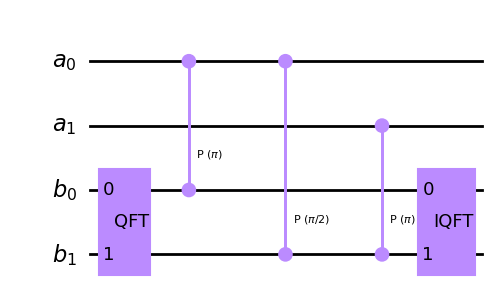

In [3]:
circ = DraperQFTAdder(2)
circ.decompose().draw('mpl')

Creating the 'ADDER' circuit as defined in the 'DraperQFTAdder' circuit:

In [4]:
ADDER = QuantumCircuit(4)
ADDER.cp(pi, 0, 2)
ADDER.cp(pi/2, 0, 3)
ADDER.cp(pi, 1, 3)

Creating the 'QFT' circuit for a 2 qubit register:

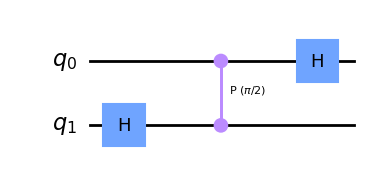

In [5]:
QFT = qft(QuantumCircuit(2), 2)
QFT.draw('mpl')

Creating the 'IQFT' circuit for a 2 qubit register:

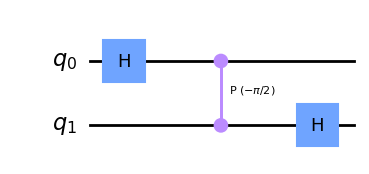

In [6]:
IQFT = inverse_qft(QuantumCircuit(2), 2)
IQFT.draw('mpl')

Create the 'QFTA' circuit by appending the previously created circuits and encoding the two, length 2 bit numbers:

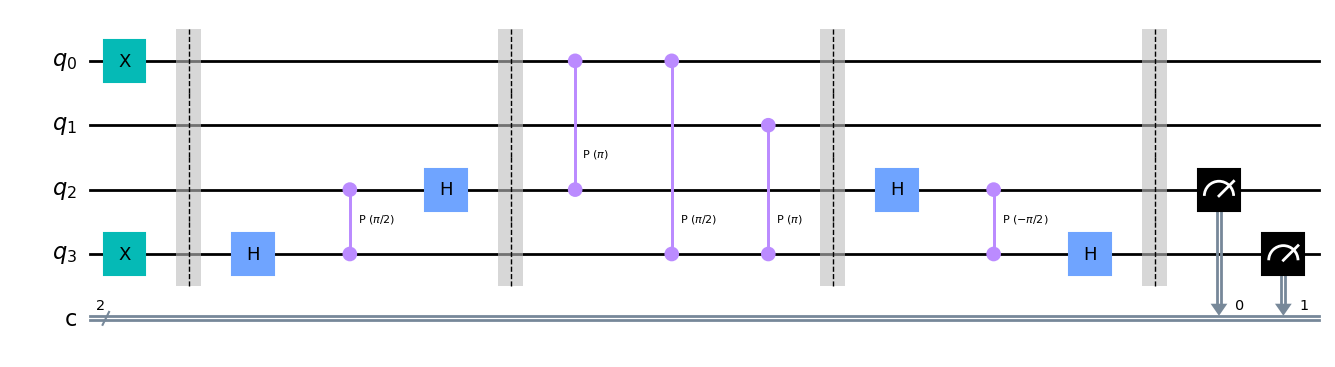

In [7]:
QFTA = QuantumCircuit(4, 2)
encode_numbers_2(QFTA, 1, 2)
QFTA.barrier()

QFTA.compose(QFT, [2, 3], inplace=True)
QFTA.barrier()
QFTA.compose(ADDER, [0, 1, 2, 3], inplace=True)
QFTA.barrier()
QFTA.compose(IQFT, [2, 3], inplace=True)
QFTA.barrier()

QFTA.measure([2, 3], [0, 1])

QFTA.draw('mpl')

Run the circuit and view the results:

In [8]:
backend = provider.get_backend('ibmq_lima')

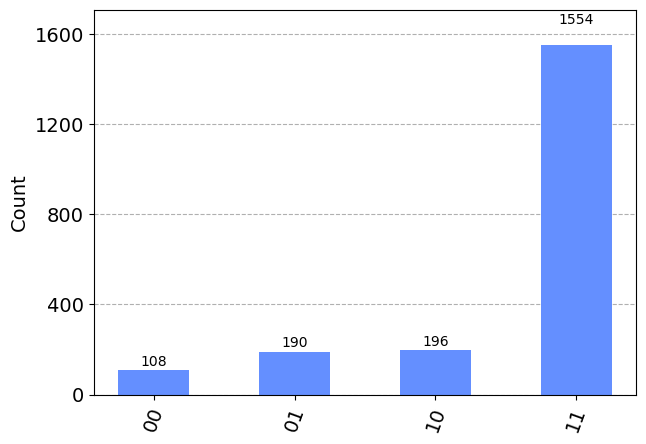

In [9]:
job1 = execute(QFTA, backend=backend, shots=2048)
result = job1.result()
counts = result.get_counts()
plot_histogram(counts)

Validation using the 'DraperQFTAdder':

In [10]:
val = QuantumCircuit(4, 2)
encode_numbers_2(val, 1, 2)
val.barrier()

draper2 = DraperQFTAdder(2)
val.compose(draper2, [0, 1, 2, 3], inplace=True)

val.measure([2, 3], [0, 1])

backend = provider.get_backend('ibmq_lima')

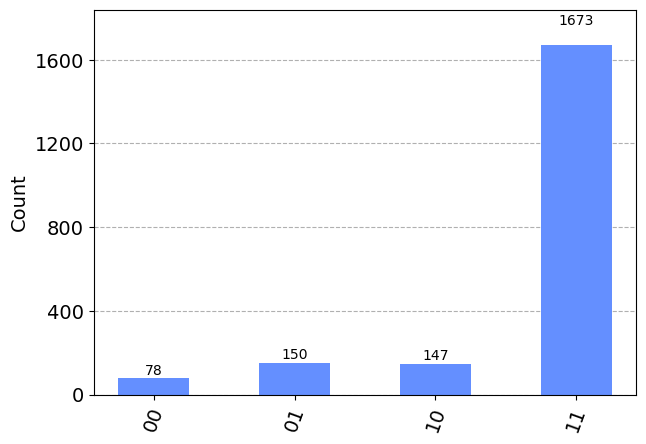

In [11]:
job2 = execute(val, backend=backend, shots=2048)
result = job2.result()
counts = result.get_counts()
plot_histogram(counts)

Below is the exploration of the DraperQFTAdder, of size 3, a circuit that uses the QFT and IQFT to compute the addition of two, 3 qubit registers:

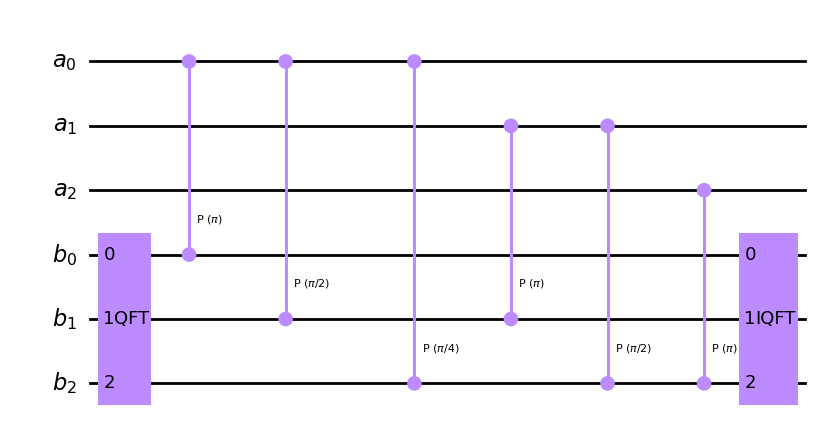

In [12]:
circ = DraperQFTAdder(3)
circ.decompose().draw('mpl')

Creating the 'ADDER' circuit as defined in the 'DraperQFTAdder' circuit:

In [13]:
ADDER = QuantumCircuit(6)
ADDER.cp(pi, 0, 3)
ADDER.cp(pi/2, 0, 4)
ADDER.cp(pi/4, 0, 5)
ADDER.cp(pi, 1, 4)
ADDER.cp(pi/2, 1, 5)
ADDER.cp(pi, 2, 5)

Creating the 'QFT' circuit for a 3 qubit register:

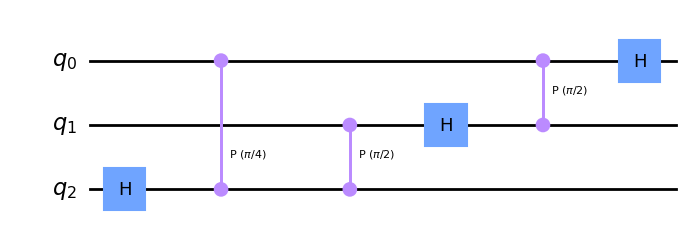

In [14]:
QFT = qft(QuantumCircuit(3), 3)
QFT.draw('mpl')

Creating the 'IQFT' circuit for a 3 qubit register:

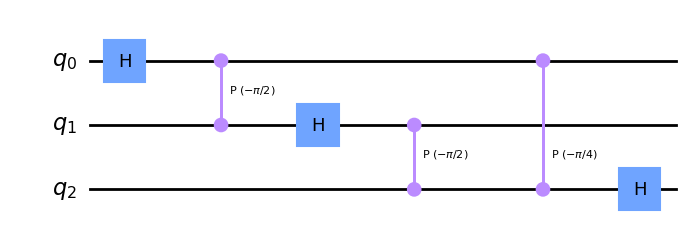

In [15]:
IQFT = inverse_qft(QuantumCircuit(3), 3)
IQFT.draw('mpl')

Create the 'QFTA' circuit by appending the previously created circuits and encoding the two, length 3 bit numbers:

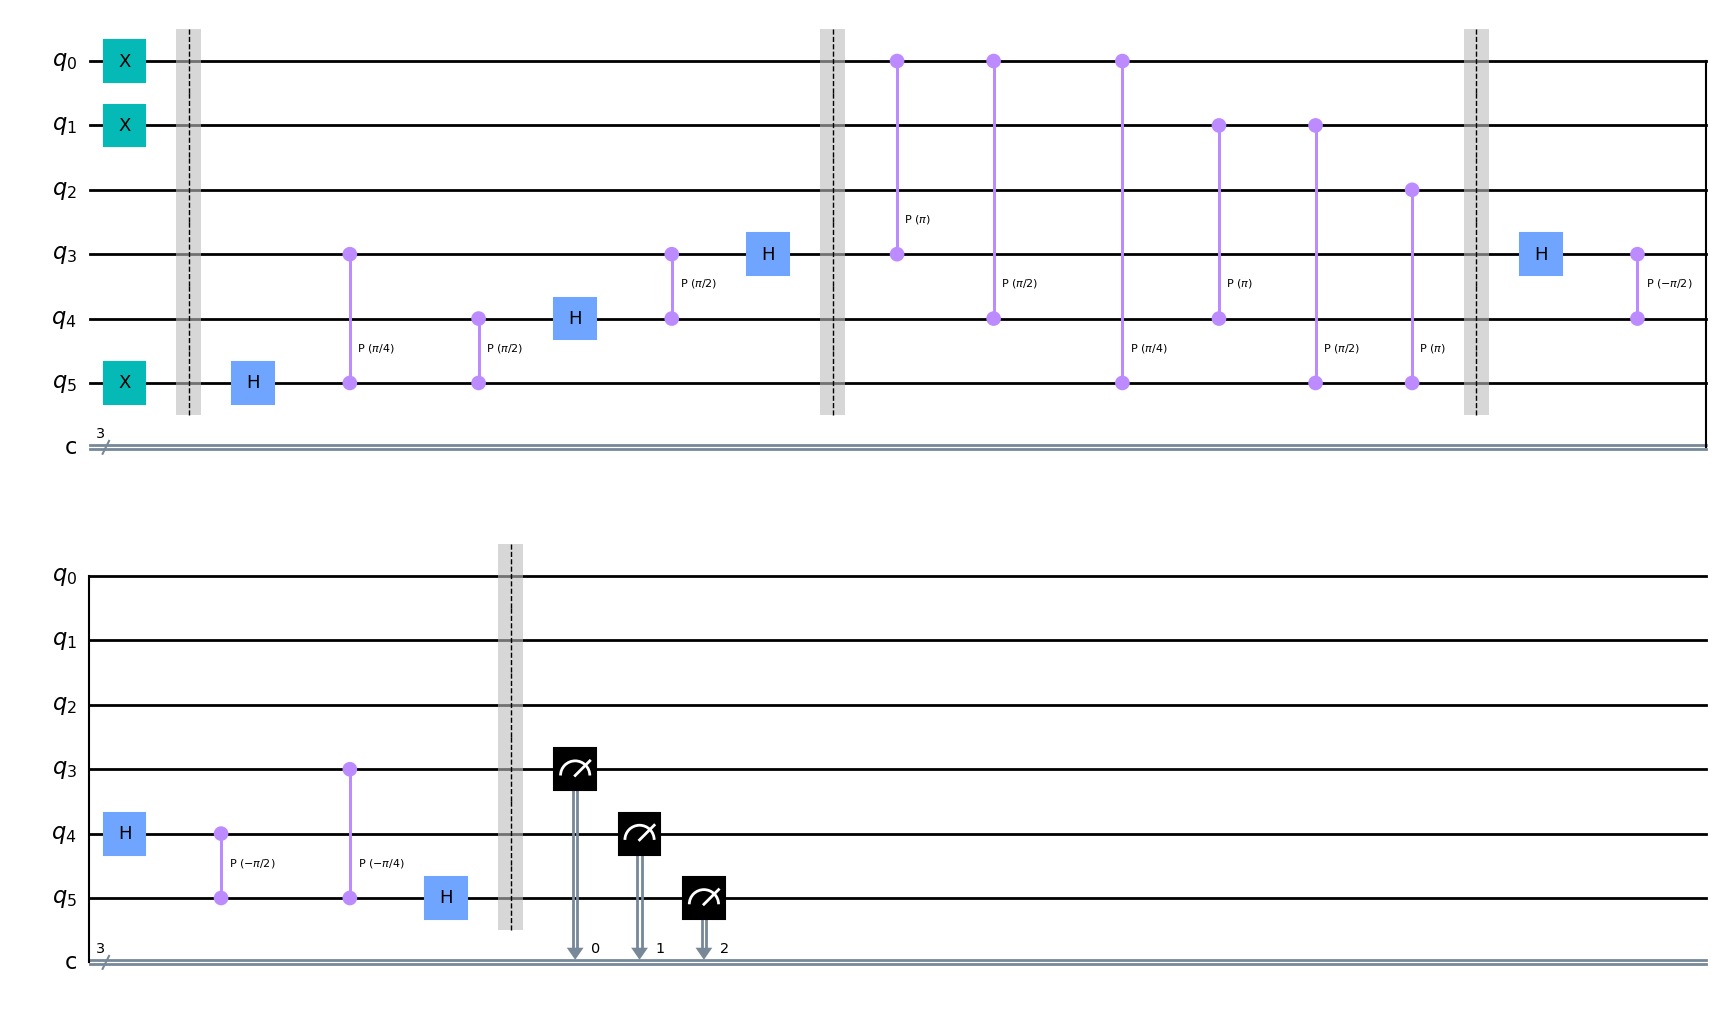

In [16]:
QFTA = QuantumCircuit(6, 3)
encode_numbers_3(QFTA, 3, 4)
QFTA.barrier()

QFTA.compose(QFT, [3, 4, 5], inplace=True)
QFTA.barrier()
QFTA.compose(ADDER, [0, 1, 2, 3, 4, 5], inplace=True)
QFTA.barrier()
QFTA.compose(IQFT, [3, 4, 5], inplace=True)
QFTA.barrier()

QFTA.measure([3, 4, 5], [0, 1, 2])

QFTA.draw('mpl')

Run the circuit and view the results:

In [17]:
backend = provider.get_backend('ibm_oslo')

In [18]:
job3 = execute(QFTA, backend=backend, shots=2048)
result = job3.result()
counts = result.get_counts()
plot_histogram(counts)

IBMQJobInvalidStateError: 'Unable to retrieve result for job ch4f4po5ngm0qhef39v0. Job was cancelled.'

Validation using the 'DraperQFTAdder':

In [ ]:
val = QuantumCircuit(6, 3)
encode_numbers_3(val, 3, 4)
val.barrier()

draper3 = DraperQFTAdder(3)
val.compose(draper3, [0, 1, 2, 3, 4, 5], inplace=True)

val.measure([3, 4, 5], [0, 1, 2])

backend = provider.get_backend('ibm_oslo')

In [ ]:
job4 = execute(val, backend=backend, shots=2048)
result = job4.result()
counts = result.get_counts()
plot_histogram(counts)